In [57]:
# imports
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

## Data Preperation

- Saving all the CSVs with descriptive names in the Folder ./original_data
- In case of XML Files the were converted to CSVs

### Google Data:

- Manuel removal of the first two rows and the region (Deutschland)
- To get weekly Data it was necessary to download several 5 year intervals and normalize/stitching them together
- Logarithmierung: Yes, because search interest data often exhibits exponential growth or decay, and log transformation helps stabilize variance and linearize trends.

### AGPI & Gebrauchtwagenpreiseindex:

- Only available on a monthly basis values were assigned to the last day of the month
- Logarithmierung: Yes, because price indices can show multiplicative effects over time, and logs convert these to additive effects, stabilizing variance.

### Arbeitslosenzahlen:

- Loaded from CSV, cleaned numeric columns (removing thousands separators, converting to appropriate types).
- 'Berichtsmonat' (reporting month) string converted to datetime objects, set to the last day of the month.
- Logarithmierung: No, the raw figures were used directly as they represent counts and rates which are often analyzed in their original scale or after differencing for stationarity.

### Euribor:

- Data for 3-month, 6-month, and 12-month Euribor rates loaded from separate CSVs.
- Unnecessary "TIME PERIOD" column dropped and columns renamed for clarity.
- Dates were already in a usable monthly format.
- Logarithmierung: No, interest rates are typically analyzed in their original percentage scale, especially when they can be near zero or negative, where logs are undefined or behave poorly.

### ifo Beschäftigungsbarometer:

- Loaded from CSV.
- "DATE" column converted to datetime objects, set to the last day of the month, then formatted as string "YYYY-MM-DD".
- Logarithmierung: No, index values like this are often used directly or differenced.

### ifo Geschäftsklima:

- Loaded from CSV.
- "DATE" column (originally in "MM/YYYY" format) converted to datetime objects, set to the last day of the month, then formatted as string "YYYY-MM-DD".
- Logarithmierung: No, similar to the Beschäftigungsbarometer, these index values are typically analyzed in their original scale.

### BMW Sales:

- Loaded from CSV, with specified separator and decimal character.
- "DATE" column converted to datetime objects.
- Logarithmierung: Yes, sales data can exhibit multiplicative seasonality and growth, log transformation helps in stabilizing variance and making the series more amenable to time series modeling.

### Verbraucherpreisindex:

- Loaded from CSV, with specified separator and decimal character.
- Numeric columns representing various price indices cleaned (commas replaced with dots, converted to float).
- "Datum" (Date) column converted to datetime objects, set to the last day of the month.
- Logarithmierung: Yes, for the selected index columns, as price indices often have multiplicative components and log transformation helps in stabilizing variance and interpreting changes as percentage changes.


In [58]:
# Log transform helper functions
def log_transform_series(series_to_log):
    return np.log(series_to_log.replace(0, np.nan))


def create_log_transformed_df(
    input_df, value_col_name, new_log_col_name, date_col_name="DATE"
):
    df_log = pd.DataFrame()
    df_log[date_col_name] = input_df[date_col_name]
    df_log[new_log_col_name] = log_transform_series(input_df[value_col_name])
    return df_log

In [59]:
# google trends
def merge_and_normalize_trends(dfs, col_name):
    # Start with the first DataFrame
    result = dfs[0].copy()
    for next_df in dfs[1:]:
        # Find overlap
        overlap = set(result["Woche"]) & set(next_df["Woche"])
        if overlap:
            # Use the mean ratio in the overlap to normalize
            overlap = list(overlap)
            result_overlap = result[result["Woche"].isin(overlap)].set_index("Woche")
            next_overlap = next_df[next_df["Woche"].isin(overlap)].set_index("Woche")
            ratio = result_overlap[col_name].mean() / next_overlap[col_name].mean()
        else:
            ratio = 1.0
        # Normalize next_df
        next_df_norm = next_df.copy()
        next_df_norm[col_name] = next_df_norm[col_name] * ratio
        # Append only non-overlapping part
        non_overlap = ~next_df_norm["Woche"].isin(result["Woche"])
        result = pd.concat([result, next_df_norm[non_overlap]], ignore_index=True)
    # Sort by date
    result = result.sort_values("Woche").reset_index(drop=True)
    return result


# Keyword: "Auto Finanzierung"
gt_auto_finanzierung_1 = pd.read_csv("./original_data/gt_auto_finanzierung_1.csv")
gt_auto_finanzierung_2 = pd.read_csv("./original_data/gt_auto_finanzierung_2.csv")
gt_auto_finanzierung_3 = pd.read_csv("./original_data/gt_auto_finanzierung_3.csv")

gt_auto_finanzierung = merge_and_normalize_trends(
    [gt_auto_finanzierung_1, gt_auto_finanzierung_2, gt_auto_finanzierung_3],
    col_name="Auto Finanzierung",
)
gt_auto_finanzierung.rename(columns={"Woche": "DATE"}, inplace=True)
gt_auto_finanzierung["DATE"] = pd.to_datetime(gt_auto_finanzierung["DATE"])
# Keyword: "BMW Finanzierung"
gt_bmw_finanzierung_1 = pd.read_csv("./original_data/gt_bmw_finanzierung_1.csv")
gt_bmw_finanzierung_2 = pd.read_csv("./original_data/gt_bmw_finanzierung_2.csv")
gt_bmw_finanzierung_3 = pd.read_csv("./original_data/gt_bmw_finanzierung_3.csv")

gt_bmw_finanzierung = merge_and_normalize_trends(
    [gt_bmw_finanzierung_1, gt_bmw_finanzierung_2, gt_bmw_finanzierung_3],
    col_name="BMW Finanzierung",
)
gt_bmw_finanzierung.rename(columns={"Woche": "DATE"}, inplace=True)
gt_bmw_finanzierung["DATE"] = pd.to_datetime(gt_bmw_finanzierung["DATE"])
# Keyword: "Auto Leasing"
gt_auto_leasing_1 = pd.read_csv("./original_data/gt_auto_leasing_1.csv")
gt_auto_leasing_2 = pd.read_csv("./original_data/gt_auto_leasing_2.csv")
gt_auto_leasing_3 = pd.read_csv("./original_data/gt_auto_leasing_3.csv")

gt_auto_leasing = merge_and_normalize_trends(
    [gt_auto_leasing_1, gt_auto_leasing_2, gt_auto_leasing_3], col_name="Auto Leasing"
)
gt_auto_leasing.rename(columns={"Woche": "DATE"}, inplace=True)
gt_auto_leasing["DATE"] = pd.to_datetime(gt_auto_leasing["DATE"])
# Keyword: "BMW Leasing"
gt_bmw_leasing_1 = pd.read_csv("./original_data/gt_bmw_leasing_1.csv")
gt_bmw_leasing_2 = pd.read_csv("./original_data/gt_bmw_leasing_2.csv")
gt_bmw_leasing_3 = pd.read_csv("./original_data/gt_bmw_leasing_3.csv")
gt_bmw_leasing = merge_and_normalize_trends(
    [gt_bmw_leasing_1, gt_bmw_leasing_2, gt_bmw_leasing_3], col_name="BMW Leasing"
)
gt_bmw_leasing.rename(columns={"Woche": "DATE"}, inplace=True)
gt_bmw_leasing["DATE"] = pd.to_datetime(gt_bmw_leasing["DATE"])
# Keyword: "Leasing"
gt_leasing_1 = pd.read_csv("./original_data/gt_leasing_1.csv")
gt_leasing_2 = pd.read_csv("./original_data/gt_leasing_2.csv")
gt_leasing_3 = pd.read_csv("./original_data/gt_leasing_3.csv")
gt_leasing = merge_and_normalize_trends(
    [gt_leasing_1, gt_leasing_2, gt_leasing_3], col_name="leasing"
)
gt_leasing.rename(columns={"Woche": "DATE"}, inplace=True)
gt_leasing["DATE"] = pd.to_datetime(gt_leasing["DATE"])
# Keyword: "BMW"
gt_bmw_1 = pd.read_csv("./original_data/gt_bmw_1.csv")
gt_bmw_2 = pd.read_csv("./original_data/gt_bmw_2.csv")
gt_bmw_3 = pd.read_csv("./original_data/gt_bmw_3.csv")
gt_bmw = merge_and_normalize_trends([gt_bmw_1, gt_bmw_2, gt_bmw_3], col_name="BMW")
gt_bmw.rename(columns={"Woche": "DATE"}, inplace=True)
gt_bmw["DATE"] = pd.to_datetime(gt_bmw["DATE"])


# Log transform
gt_bmw_leasing_log = create_log_transformed_df(
    gt_bmw_leasing, "BMW Leasing", "BMWLeasing"
)
gt_bmw_finanzierung_log = create_log_transformed_df(
    gt_bmw_finanzierung, "BMW Finanzierung", "BMWFinanzierung"
)
gt_auto_finanzierung_log = create_log_transformed_df(
    gt_auto_finanzierung, "Auto Finanzierung", "AutoFinanzierung"
)
gt_auto_leasing_log = create_log_transformed_df(
    gt_auto_leasing, "Auto Leasing", "AutoLeasing"
)
gt_leasing_log = create_log_transformed_df(gt_leasing, "leasing", "leasing")
gt_bmw_log = create_log_transformed_df(gt_bmw, "BMW", "BMW")

In [60]:
# agpi
agpi = pd.read_csv("./original_data/agpi.csv")

agpi["DATE"] = pd.to_datetime(agpi["DATE"], format="%Y-%m") + pd.offsets.MonthEnd(0)
# agpi["DATE"] = agpi["DATE"].dt.strftime("%Y-%m-%d") # Keep as datetime

agpi_log = create_log_transformed_df(agpi, "AGPI", "AGPI")

In [61]:
# gebrauchtwagenpreiseindex

gebrauchtwagenpreisindex = pd.read_csv("./original_data/gebrauchtwagenpreisindex.csv")
gebrauchtwagenpreisindex["DATE"] = pd.to_datetime(
    gebrauchtwagenpreisindex["DATE"], errors="coerce"
) + pd.offsets.MonthEnd(0)
# gebrauchtwagenpreisindex["DATE"] = gebrauchtwagenpreisindex["DATE"].dt.strftime( # Keep as datetime
#     "%Y-%m-%d"
# )

gebrauchtwagenpreisindex_log = create_log_transformed_df(
    gebrauchtwagenpreisindex, "Gebrauchtwagenpreisindex", "Gebrauchtwagenpreisindex"
)

In [62]:
# arbeitslosenzahlen

month_map = {
    "Januar": "01",
    "Februar": "02",
    "März": "03",
    "April": "04",
    "Mai": "05",
    "Juni": "06",
    "Juli": "07",
    "August": "08",
    "September": "09",
    "Oktober": "10",
    "November": "11",
    "Dezember": "12",
}
arbeitslosenquote = pd.read_csv(
    "./original_data/arbeitslosenzahlen.csv", sep=";", decimal=","
)

# Clean integer columns (remove dots, convert to int)
for col in ["Bestand Arbeitslose", "Zugang Arbeitslose", "Abgang Arbeitslose"]:
    arbeitslosenquote[col] = (
        arbeitslosenquote[col]
        .astype(str)
        .str.replace(".", "", regex=False)
        .replace("", "0")
        .astype(int)
    )

# Clean float column (replace comma with dot, convert to float)
arbeitslosenquote["Arbeitslosenquote"] = (
    arbeitslosenquote["Arbeitslosenquote"]
    .astype(str)
    .str.replace(",", ".", regex=False)
    .replace("", "0")
    .astype(float)
)

# Convert 'Berichtsmonat' to datetime
arbeitslosenquote["DATE"] = (
    arbeitslosenquote["Berichtsmonat"]
    .astype(str)
    .apply(
        lambda x: pd.to_datetime(
            f"{x.split(' ')[1]}-{month_map.get(x.split(' ')[0], '01')}-01",
            errors="coerce",
        )
    )
)
arbeitslosenquote["DATE"] = arbeitslosenquote["DATE"] + pd.offsets.MonthEnd(0)

# Reorder columns
arbeitslosenquote = arbeitslosenquote.drop(columns=["Berichtsmonat"])
arbeitslosenquote = arbeitslosenquote[
    ["DATE"] + [col for col in arbeitslosenquote.columns if col != "DATE"]
]

In [63]:
# euribor
# 3 months
euribor_3m = pd.read_csv("./original_data/euribor_3m.csv")
euribor_3m = euribor_3m.drop(columns=["TIME PERIOD"])
euribor_3m = euribor_3m.rename(
    columns={
        "Euribor 3-month - Historical close, average of observations through period (FM.M.U2.EUR.RT.MM.EURIBOR3MD_.HSTA)": "Euribor 3M"
    }
)
# 6 months
euribor_6m = pd.read_csv("./original_data/euribor_6m.csv")
euribor_6m = euribor_6m.drop(columns=["TIME PERIOD"])
euribor_6m = euribor_6m.rename(
    columns={
        "Euribor 6-month - Historical close, average of observations through period (FM.M.U2.EUR.RT.MM.EURIBOR6MD_.HSTA)": "Euribor 6M"
    }
)
# 12 months
euribor_12m = pd.read_csv("./original_data/euribor_12m.csv")
euribor_12m = euribor_12m.drop(columns=["TIME PERIOD"])
euribor_12m = euribor_12m.rename(
    columns={
        "Euribor 1-year - Historical close, average of observations through period (FM.M.U2.EUR.RT.MM.EURIBOR1YD_.HSTA)": "Euribor 12M"
    }
)

In [64]:
# ifo beschäftigungsbarometer
beschaeftigungsbarometer = pd.read_csv(
    "./original_data/ifo_beschaeftigungsbarometer.csv"
)
beschaeftigungsbarometer["DATE"] = pd.to_datetime(
    beschaeftigungsbarometer["DATE"], errors="coerce"
) + pd.offsets.MonthEnd(0)
beschaeftigungsbarometer["DATE"] = beschaeftigungsbarometer["DATE"].dt.strftime(
    "%Y-%m-%d"
)

In [65]:
# ifo geschäftsklima
geschaeftsklima = pd.read_csv("./original_data/ifo_geschaeftsklima.csv")
geschaeftsklima["DATE"] = pd.to_datetime(
    geschaeftsklima["DATE"].str.strip(), format="%m/%Y"
) + pd.offsets.MonthEnd(0)
geschaeftsklima["DATE"] = geschaeftsklima["DATE"].dt.strftime("%Y-%m-%d")

In [66]:
# bmw sales
bmw_sales = pd.read_csv("./original_data/bmw_sales.csv", sep=";", decimal=",")
bmw_sales["DATE"] = pd.to_datetime(bmw_sales["DATE"])  # Ensure DATE is datetime

bmw_sales_log = create_log_transformed_df(bmw_sales, "SALES", "SALES")

In [67]:
# verbraucherpreisindex
verbraucherpreisindex = pd.read_csv(
    "./original_data/verbraucherpreisindex.csv", sep=";", decimal=","
)

# Columns to clean: replace comma with period and convert to float
cols_to_clean_comma = [
    "Index der Erzeugerpreise gewerblicher Produkte",
    "Index der Einfuhrpreise",
    "Index der Ausfuhrpreise",
]

for col in cols_to_clean_comma:
    verbraucherpreisindex[col] = (
        verbraucherpreisindex[col]
        .astype(str)
        .str.replace(",", ".", regex=False)
        .replace(
            ".", "0", regex=False
        )  # Handle cases where only a period might be left or as a placeholder
        .replace("", "0")  # Replace empty strings with 0
        .astype(float)
    )

# Convert "Datum" to datetime, then set to last day of month
verbraucherpreisindex["DATE"] = pd.to_datetime(
    verbraucherpreisindex["Datum"], format="%d/%m/%Y"
) + pd.offsets.MonthEnd(0)
# verbraucherpreisindex["DATE"] = verbraucherpreisindex["DATE"].dt.strftime("%Y-%m-%d") # Keep as datetime
verbraucherpreisindex = verbraucherpreisindex.drop(columns=["Datum"])
cols = ["DATE"] + [col for col in verbraucherpreisindex.columns if col != "DATE"]
verbraucherpreisindex = verbraucherpreisindex[cols]

# Log-transform selected columns (except DATE)
cols_to_log = [
    "Verbraucherpreisindex",
    "Index der Einzelhandelspreise",
    "Index der Erzeugerpreise gewerblicher Produkte",
    "Index der Growsshandelsverkaufspreise",
    "Index der Einfuhrpreise",
    "Index der Ausfuhrpreise",
]

verbraucherpreisindex_log = verbraucherpreisindex[["DATE"] + cols_to_log].copy()
for col in cols_to_log:
    verbraucherpreisindex_log[col] = log_transform_series(
        verbraucherpreisindex_log[col]
    )

## Data Merging, Interpolation and converting to a weekly-basis

### Merging

- Array with all the dataframes, which should be merged
- Using lambda function tou outer join all the dataframes using the DATE as a index
- Exporting merged dataframe to data.csv
- Describing the Data to gather more insights

### Interpolation

- Filling missing Values using interpolation via the time method

### Weekly-basis

- Using the Sunday of each Week as a common Basis


In [68]:
# Merge all dataframes on DATE
from functools import reduce

dataframes = [
    bmw_sales_log,
    gt_auto_finanzierung_log,
    gt_bmw_finanzierung_log,
    gt_auto_leasing_log,
    gt_bmw_leasing_log,
    gt_leasing_log,
    gt_bmw_log,
    agpi_log,
    gebrauchtwagenpreisindex_log,
    euribor_3m,
    euribor_6m,
    euribor_12m,
    verbraucherpreisindex_log,
    arbeitslosenquote,
    beschaeftigungsbarometer,
    geschaeftsklima,
]

# Ensure all DATE columns are in datetime format
for df_item in dataframes:
    if "DATE" in df_item.columns:
        df_item["DATE"] = pd.to_datetime(df_item["DATE"])

merged = reduce(
    lambda left, right: pd.merge(left, right, on="DATE", how="outer"), dataframes
)
merged.columns = merged.columns.str.replace(r"\s+", "", regex=True)
merged.to_csv("data.csv", index=False)

In [69]:
merged.describe()

,DATE,SALES,AutoFinanzierung,BMWFinanzierung,AutoLeasing,BMWLeasing,leasing,BMW,AGPI,Gebrauchtwagenpreisindex,...,Arbeitslosenquote,Beschäftigungsbarometer,VerarbeitendesGewerbe,Bauhauptgewerbe,Handel,Dienstleistungssektor,Geschäftsklima,Geschäftslage,Geschäftserwartungen,Konjunkturampel
count,902,542.000000,543.000000,542.000000,543.000000,543.000000,543.000000,543.000000,70.000000,124.000000,...,216.000000,280.000000,280.000000,280.000000,280.000000,280.000000,244.000000,244.000000,244.000000,244.000000
mean,2015-10-25 04:40:58.536585216,8.325527,4.326917,3.915867,4.578721,4.373930,4.447734,4.321951,10.091991,4.831985,...,6.429630,97.577857,-5.296786,-6.657143,-4.851071,6.669286,95.685246,95.872541,95.607787,57.623361
min,1994-01-31 00:00:00,7.121252,3.583519,2.955798,3.761200,3.818107,3.713572,3.962044,9.892275,4.605170,...,4.800000,86.800000,-40.000000,-46.200000,-34.700000,-18.300000,75.000000,77.500000,71.000000,0.000000
25%,2012-11-07 12:00:00,8.185768,4.219508,3.714663,4.317488,4.248495,4.234107,4.230308,9.944569,4.701162,...,5.700000,93.575000,-15.325000,-11.025000,-11.800000,0.600000,91.175000,90.850000,92.500000,22.300000
50%,2018-03-02 00:00:00,8.328209,4.330733,3.937685,4.620164,4.371875,4.501427,4.317488,10.130366,4.775335,...,6.300000,98.600000,-3.700000,-2.750000,-1.950000,8.200000,97.900000,97.900000,97.850000,70.800000
75%,2021-10-08 06:00:00,8.476266,4.442651,4.124562,4.861074,4.496866,4.665396,4.392827,10.212561,4.938939,...,7.100000,100.600000,3.450000,2.400000,2.700000,12.300000,100.125000,100.500000,100.525000,92.350000
max,2025-05-18 00:00:00,8.920656,4.758516,4.605170,5.802430,4.867930,5.117613,6.002265,10.286468,5.145166,...,9.100000,105.000000,20.400000,18.400000,10.100000,22.600000,105.000000,108.500000,106.100000,100.000000
std,NaN,0.216636,0.184259,0.285749,0.355380,0.167837,0.267806,0.173448,0.137958,0.144366,...,1.041623,4.394736,12.519835,15.155326,9.939559,7.778201,6.108702,7.074345,6.624954,35.883843


In [70]:
# Data transformation

# Ensure 'DATE' column is datetime
merged["DATE"] = pd.to_datetime(merged["DATE"])
merged = merged.sort_values("DATE").reset_index(drop=True)

# Interpolate on the original merged data
interpolated_on_original_timeline = (
    merged.set_index("DATE")
    .interpolate(method="time", limit_direction="both")
    .reset_index()
)

# Weekly (Sunday) index
all_sundays_index = pd.date_range(
    start=merged["DATE"].min(), end=merged["DATE"].max(), freq="W-SUN", name="DATE"
)

# Align the broadly interpolated data to the target weekly (Sunday) index
interpolated_on_original_timeline = interpolated_on_original_timeline.set_index("DATE")

# Reindex to the all_sundays_index
data_aligned_to_sundays = interpolated_on_original_timeline.reindex(all_sundays_index)

# Interpolate again to fill any NaNs created by reindexing to Sundays
interpolated = data_aligned_to_sundays.interpolate(
    method="time", limit_direction="both"
).reset_index()

final_start_date = pd.Timestamp("2015-01-01")
interpolated = interpolated[interpolated["DATE"] >= final_start_date].reset_index(
    drop=True
)

## Seasonal adjustment using STL

- Defining, which columns should be saisonal adjusted
- Using 52 as period, beause 52 weeks are in a year --> repetition


In [71]:
# seasonal adjustment
from statsmodels.tsa.seasonal import STL

# List of columns to be seasonally adjusted
seasonal_cols = [
    "SALES",
    "AutoFinanzierung",
    "BMWFinanzierung",
    "AutoLeasing",
    "BMWLeasing",
    "leasing",
    "BMW",
    "AGPI",
    "Gebrauchtwagenpreisindex",
    "Euribor3M",
    "Euribor6M",
    "Euribor12M",
    "BestandArbeitslose",
    "ZugangArbeitslose",
    "AbgangArbeitslose",
    "Arbeitslosenquote",
    "Beschäftigungsbarometer",
    "VerarbeitendesGewerbe",
    "Bauhauptgewerbe",
    "Handel",
    "Dienstleistungssektor",
    "Geschäftsklima",
    "Geschäftslage",
    "Geschäftserwartungen",
    "Konjunkturampel",
]

df_sa = interpolated.copy()
df_sa = df_sa.set_index("DATE")

for col in seasonal_cols:
    if col in df_sa.columns:
        series = df_sa[col].dropna()
        if len(series) > 2 * 52:  # Check if enough data points (period=52 weeks)
            stl = STL(series, period=52, robust=True)
            res = stl.fit()
            df_sa[col] = pd.Series(res.trend + res.resid, index=series.index)

df_sa = df_sa.reset_index()

## Plotting of the time series to gather more insights


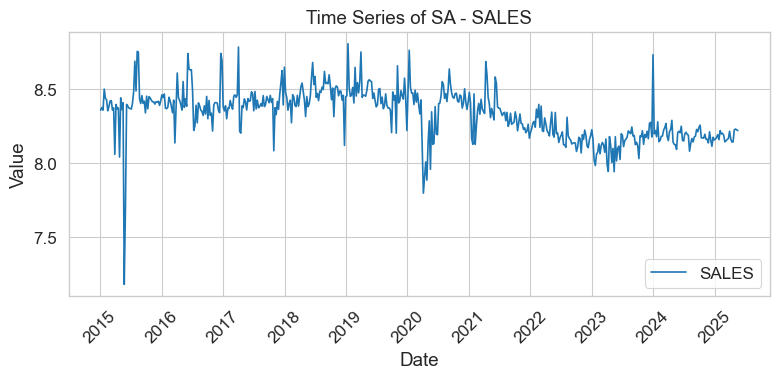

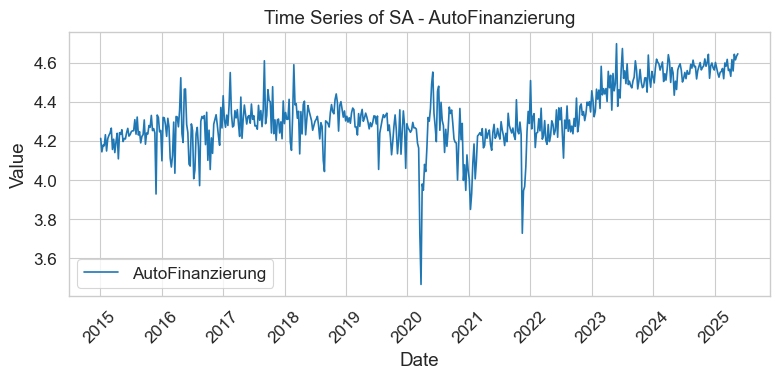

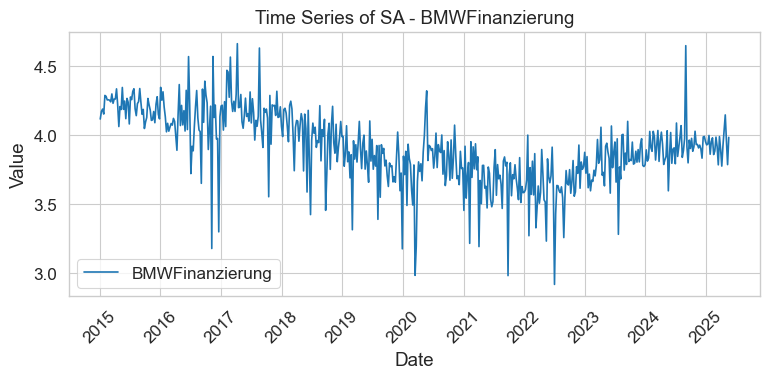

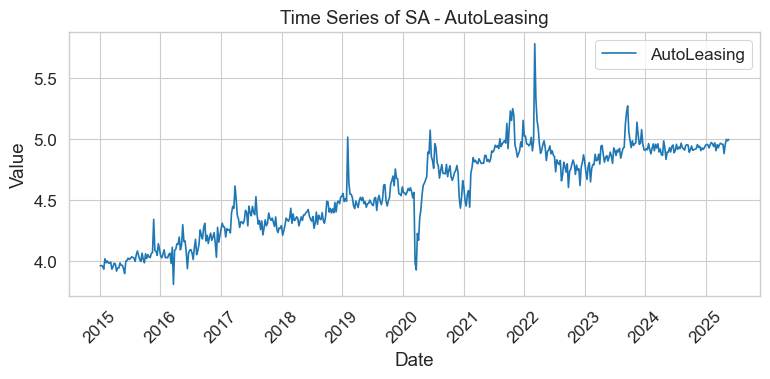

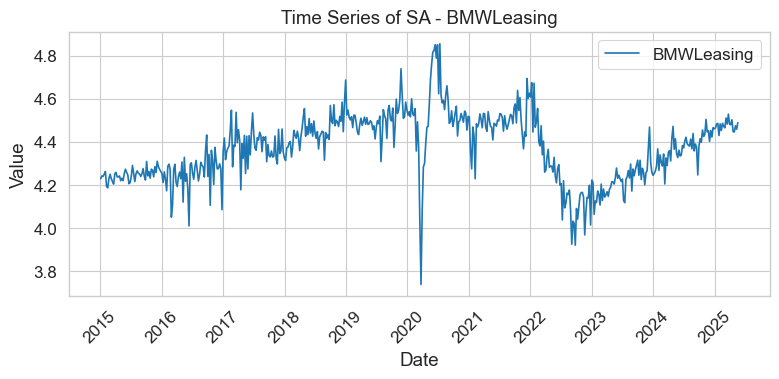

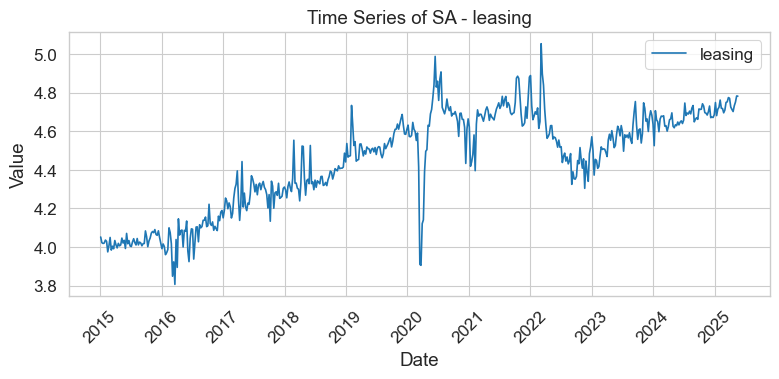

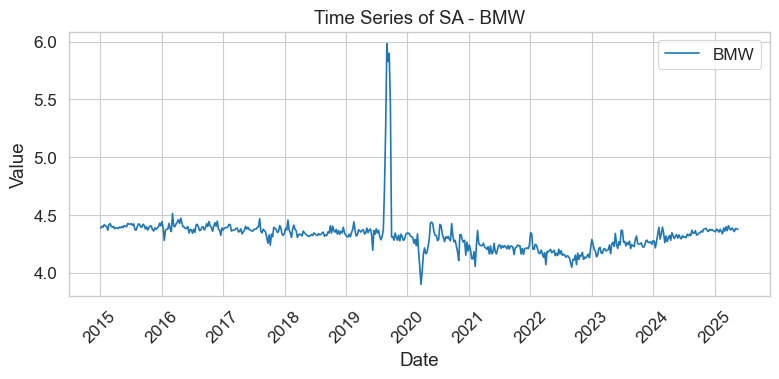

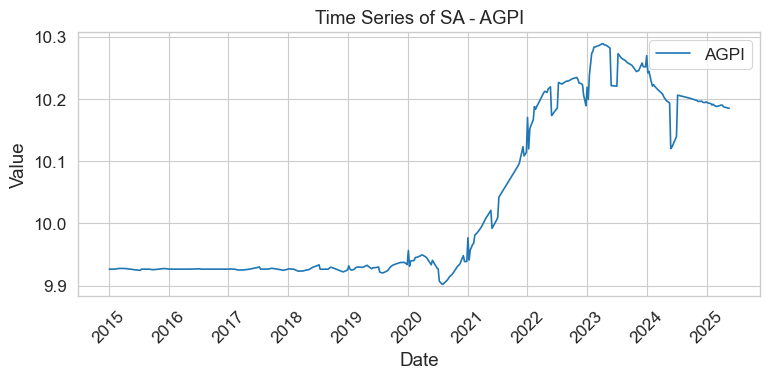

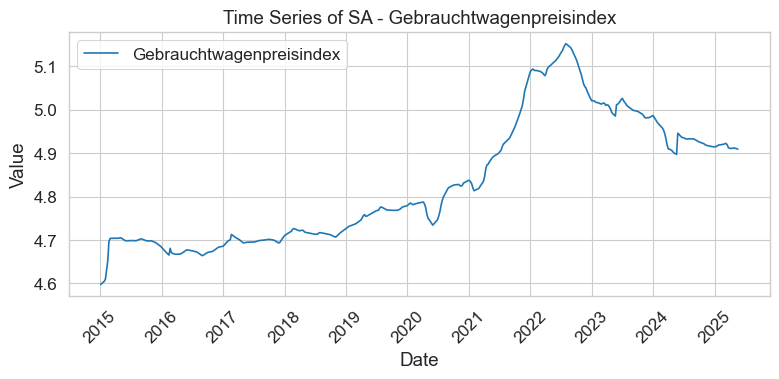

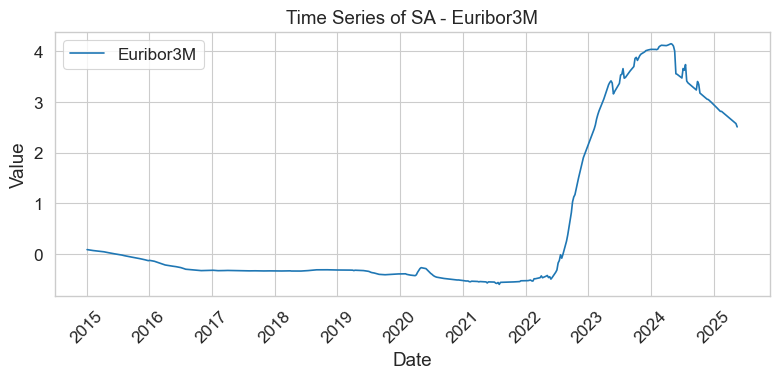

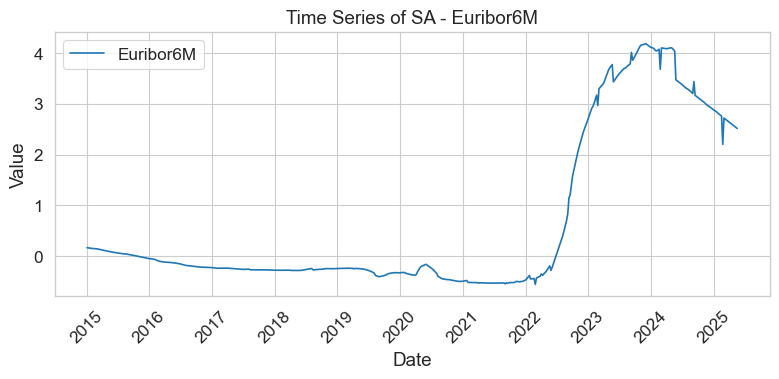

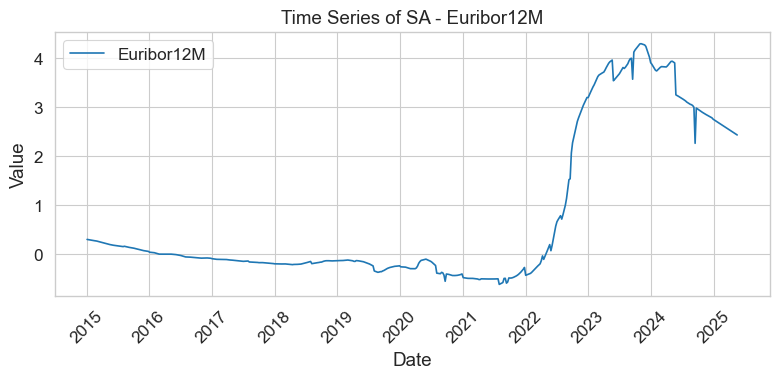

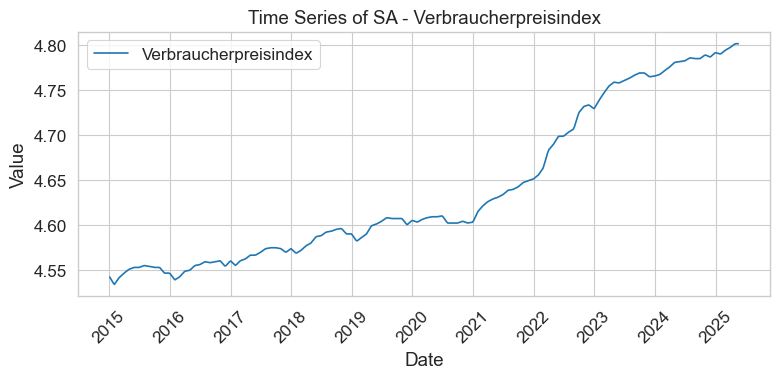

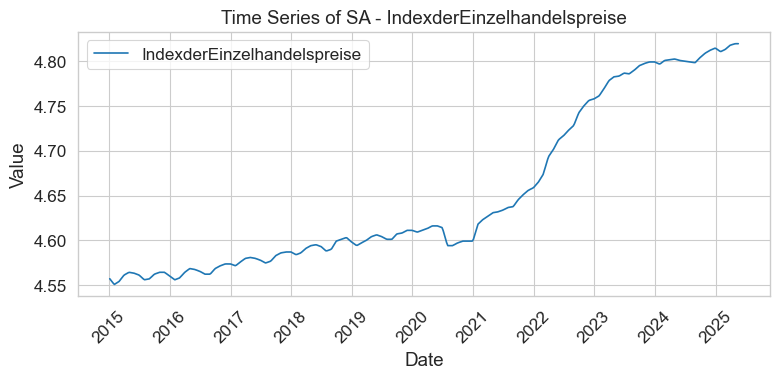

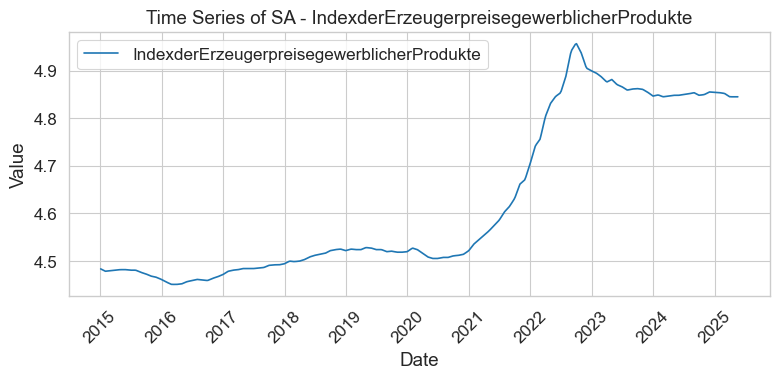

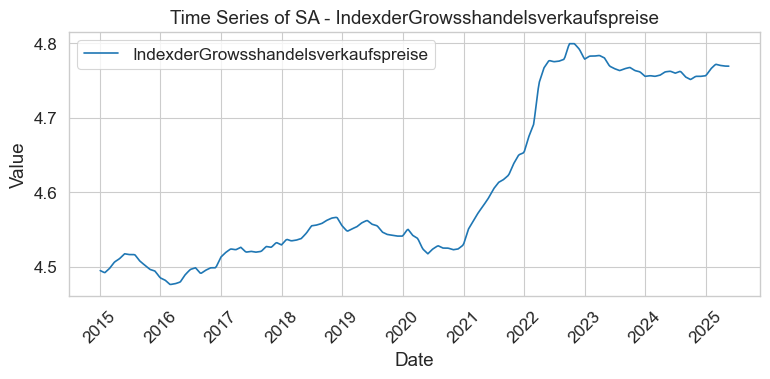

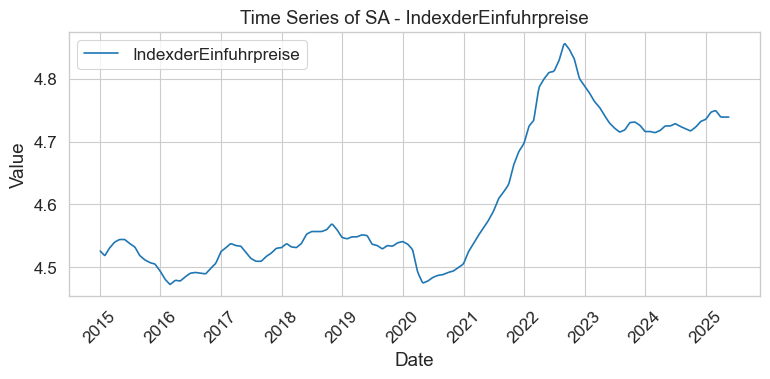

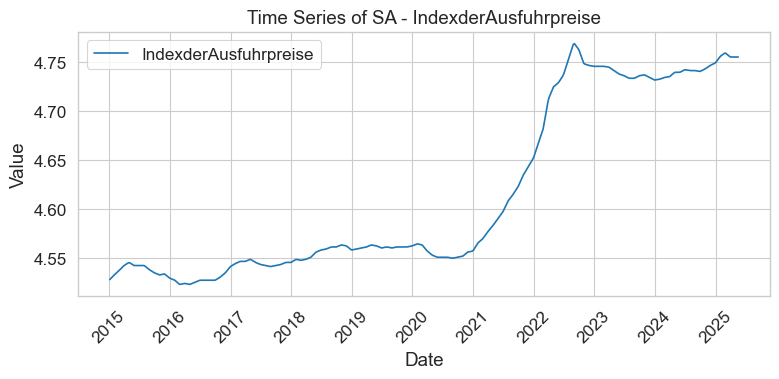

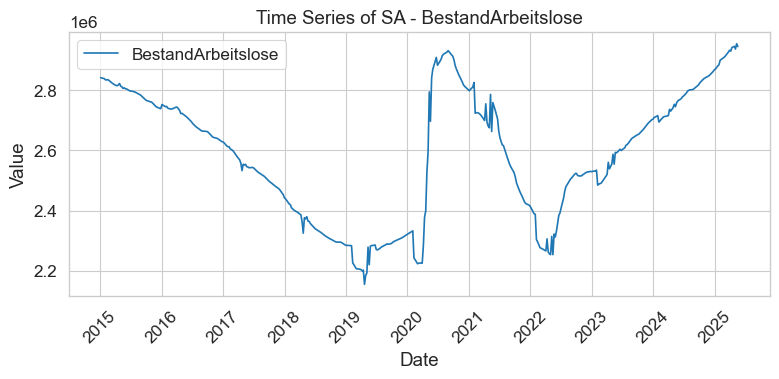

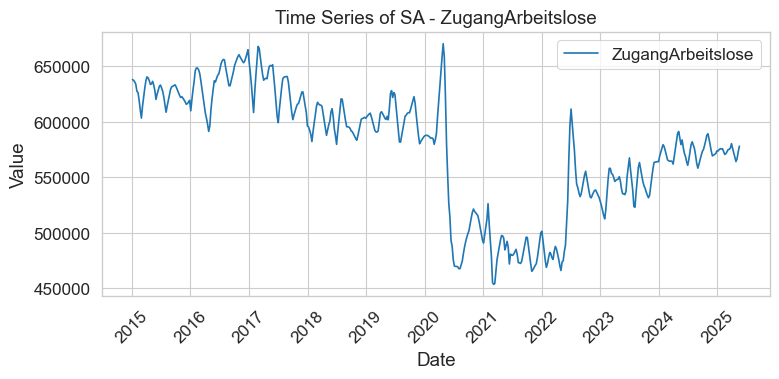

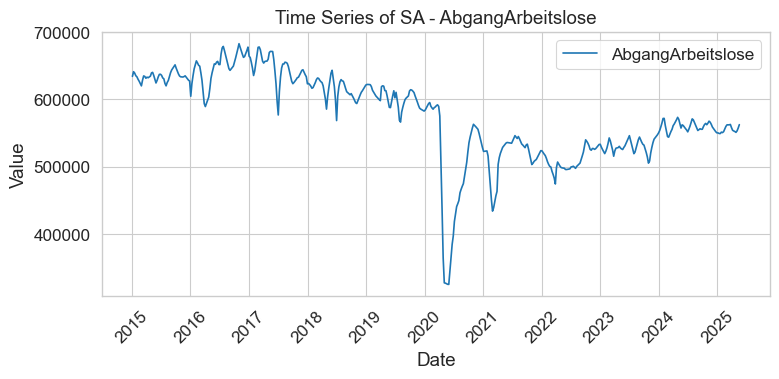

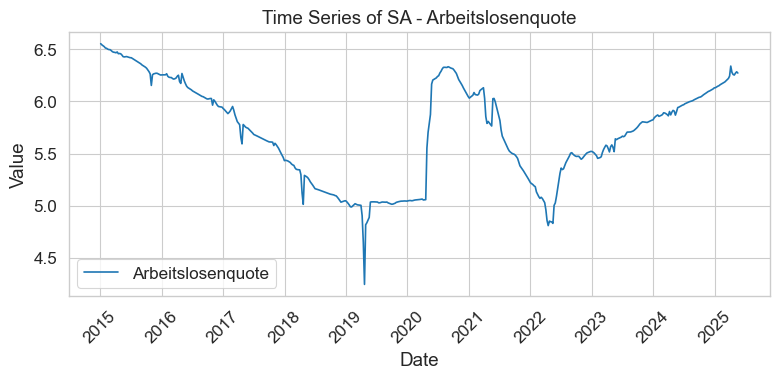

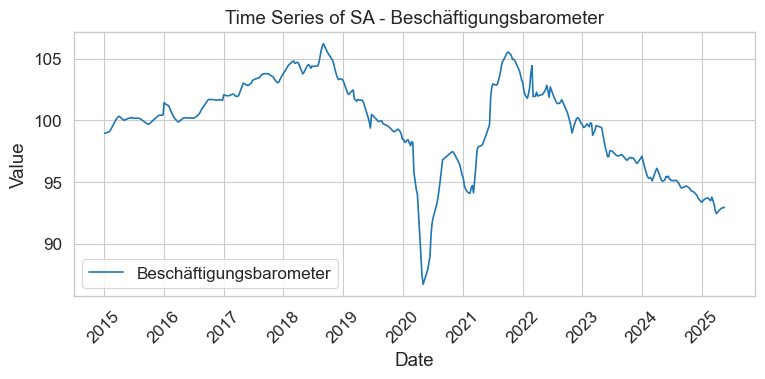

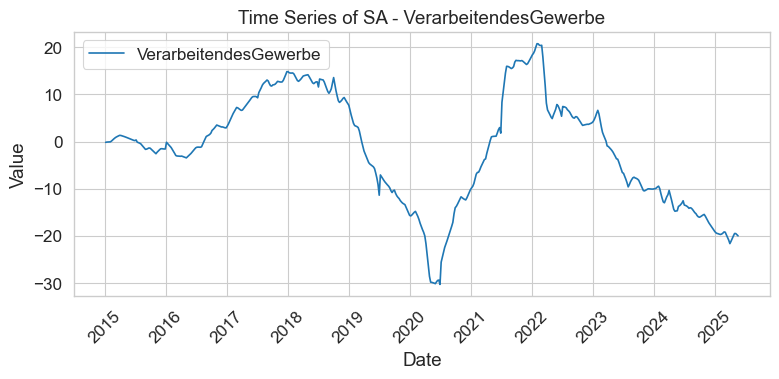

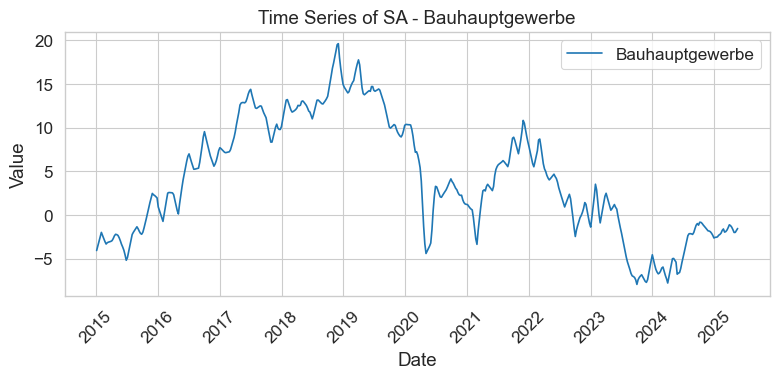

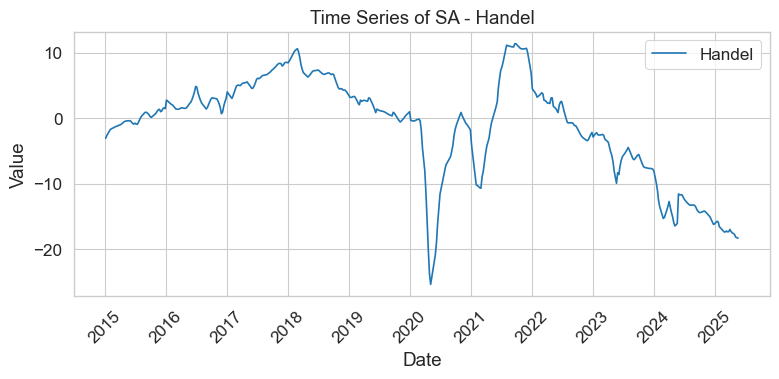

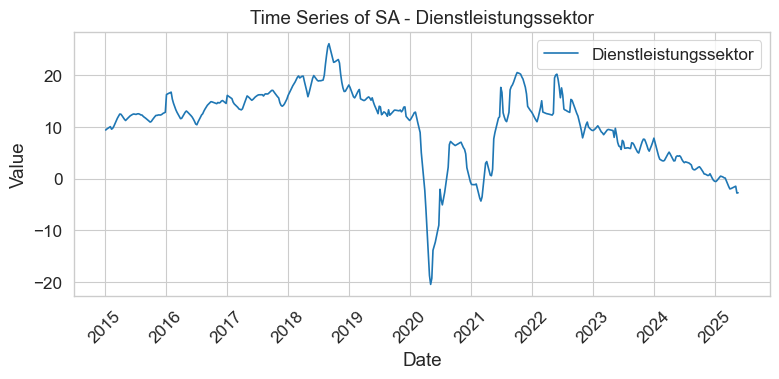

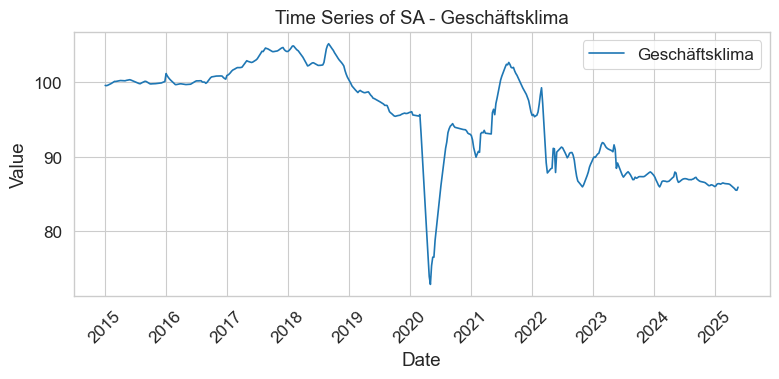

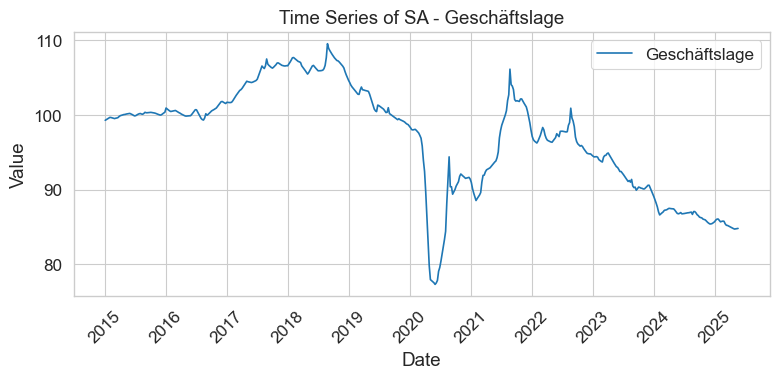

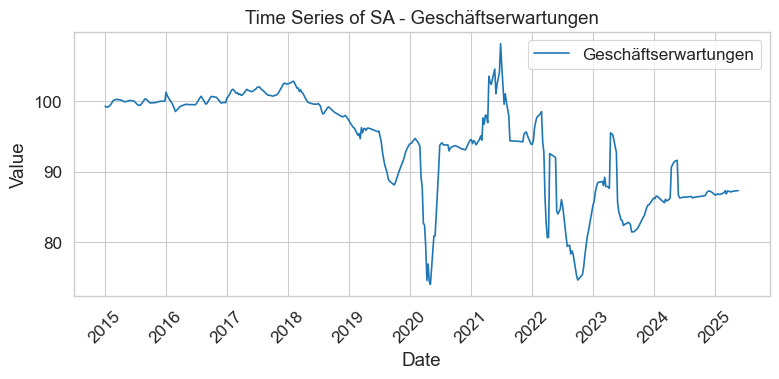

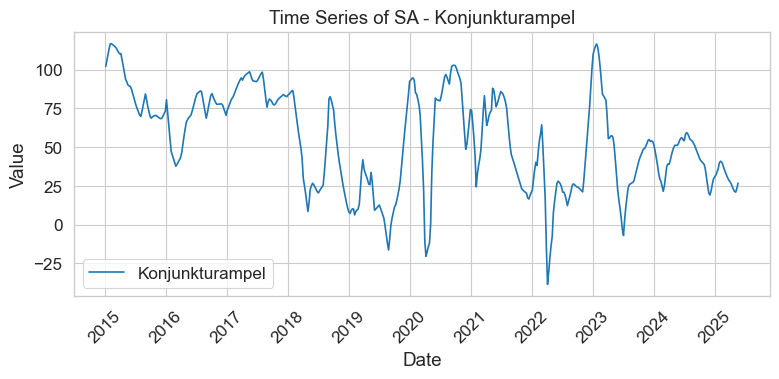

In [72]:
# Plotting Time Series
def plot_time_series(df, title, x_col="DATE", y_cols=None):
    import matplotlib.dates as mdates

    if y_cols is None:
        y_cols = [col for col in df.columns if col != x_col]  # All columns except x_col

    # Ensure x_col is datetime
    df_plot = df.copy()
    if not pd.api.types.is_datetime64_any_dtype(df_plot[x_col]):
        df_plot[x_col] = pd.to_datetime(df_plot[x_col])

    for col in y_cols:
        if col in df_plot.columns:  # Check if column exists
            plt.figure(figsize=(8, 4))
            plt.plot(df_plot[x_col], df_plot[col], label=col)
            plt.title(f"{title} - {col}")
            plt.xlabel("Date")
            plt.ylabel("Value")

            # Set x-axis major ticks to yearly
            ax = plt.gca()
            ax.xaxis.set_major_locator(mdates.YearLocator())
            ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))

            plt.legend()
            plt.grid(True)
            plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
            plt.tight_layout()  # Adjust layout to prevent labels from overlapping
            plt.show()
        else:
            print(f"Warning: Column '{col}' not found in DataFrame.")


plot_time_series(df_sa, "Time Series of SA")

## Testing the stationarity of the Data


In [73]:
# Testing Stationarity Functions
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# # Plot ACF and PACF
# def plot_acf_pacf(series, lags=40, title="ACF and PACF"):
#     fig, ax = plt.subplots(1, 2, figsize=(12, 5))
#     plot_acf(series, lags=lags, ax=ax[0])
#     plot_pacf(series, lags=lags, ax=ax[1])
#     ax[0].set_title(f"{title} - ACF")
#     ax[1].set_title(f"{title} - PACF")
#     plt.tight_layout()
#     plt.show()

# plot_acf_pacf(df_sa["SALES"], title="BMW Sales ACF and PACF")

# ADF test
def adf_test(series, title):
    result = adfuller(series, autolag="AIC", regression="ct")
    print(f"ADF Test: {title}")
    print(f"ADF Statistic: {result[0]}")
    print(f"p-value: {result[1]}")
    print(f"Critical Values:")
    for key, value in result[4].items():
        print(f"\t{key}: {value}")


adf_test(df_sa["AGPI"], title="AGPI")


# KPSS test
def kpss_test(series, title):
    result = kpss(series, regression="ct")
    print(f"KPSS Test: {title}")
    print(f"KPSS Statistic: {result[0]}")
    print(f"p-value: {result[1]}")
    print(f"Critical Values:")
    for key, value in result[3].items():
        print(f"\t{key}: {value}")
    print("\n")


kpss_test(df_sa["AGPI"], title="AGPI")

ADF Test: AGPI
ADF Statistic: -1.5570064770544134
p-value: 0.808815470692549
Critical Values:
	1%: -3.975920871028089
	5%: -3.418790523299655
	10%: -3.1319333730441183
KPSS Test: AGPI
KPSS Statistic: 0.5306360778466285
p-value: 0.01
Critical Values:
	10%: 0.119
	5%: 0.146
	2.5%: 0.176
	1%: 0.216




/tmp/ipykernel_5819/3213229295.py:33: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series, regression="ct")


In [74]:
# Check all columns for stationarity



In [75]:
# Define the function to difference specified columns in a DataFrame
def difference_df_columns(input_df, columns_to_difference, periods=1):
    df_out = input_df.copy()  # Work on a copy
    for col in columns_to_difference:
        if col in df_out.columns:
            df_out[col] = df_out[col].diff(periods=periods)
        else:
            print(f"Warning: Column '{col}' not found in DataFrame for differencing.")
    return df_out


cols_to_make_stationary = [
    "SALES",
    "AutoFinanzierung",
    "BMWFinanzierung",
    "AutoLeasing",
    "BMWLeasing",
    "leasing",
    "BMW",
    "AGPI",
    "Gebrauchtwagenpreisindex",
    "Euribor3M",
    "Euribor6M",
    "Euribor12M",
    "Verbraucherpreisindex",
    "IndexderEinzelhandelspreise",
    "IndexderErzeugerpreisegewerblicherProdukte",
    "IndexderGrowsshandelsverkaufspreise",
    "IndexderEinfuhrpreise",
    "IndexderAusfuhrpreise",
    "BestandArbeitslose",
    "ZugangArbeitslose",
    "AbgangArbeitslose",
    "Arbeitslosenquote",
    "Beschäftigungsbarometer",
    "VerarbeitendesGewerbe",
    "Bauhauptgewerbe",
    "Handel",
    "Dienstleistungssektor",
    "Geschäftsklima",
    "Geschäftslage",
    "Geschäftserwartungen",
    "Konjunkturampel",
]

df_sa = difference_df_columns(df_sa, cols_to_make_stationary, periods=1)

for col_name in cols_to_make_stationary:
    if col_name in df_sa.columns:
        series_for_test = df_sa[col_name].dropna()

        if not series_for_test.empty:
            print(f"--- Stationarity Test for Differenced '{col_name}' in df_sa ---")
            adf_test(series_for_test, title=f"Differenced {col_name} (ADF)")
            kpss_test(series_for_test, title=f"Differenced {col_name} (KPSS)")
        else:
            print(
                f"Series for '{col_name}' is empty after differencing and dropping NaNs. Cannot perform stationarity test."
            )
    else:
        print(
            f"Column '{col_name}' was not found in df_sa after the differencing attempt."
        )

--- Stationarity Test for Differenced 'SALES' in df_sa ---
ADF Test: Differenced SALES (ADF)
ADF Statistic: -9.142409490434506
p-value: 1.7336630683760596e-13
Critical Values:
	1%: -3.976018905537762
	5%: -3.4188378719568053
	10%: -3.1319612007373583
KPSS Test: Differenced SALES (KPSS)
KPSS Statistic: 0.034106737568639064
p-value: 0.1
Critical Values:
	10%: 0.119
	5%: 0.146
	2.5%: 0.176
	1%: 0.216


--- Stationarity Test for Differenced 'AutoFinanzierung' in df_sa ---
ADF Test: Differenced AutoFinanzierung (ADF)
ADF Statistic: -9.386279613507437
p-value: 4.9530284388129515e-14
Critical Values:
	1%: -3.9761180672411185
	5%: -3.4188857639062733
	10%: -3.131989347405248
KPSS Test: Differenced AutoFinanzierung (KPSS)
KPSS Statistic: 0.033086977088557144
p-value: 0.1
Critical Values:
	10%: 0.119
	5%: 0.146
	2.5%: 0.176
	1%: 0.216


--- Stationarity Test for Differenced 'BMWFinanzierung' in df_sa ---
ADF Test: Differenced BMWFinanzierung (ADF)
ADF Statistic: -10.237021280138043
p-value: 7.34

/tmp/ipykernel_5819/3213229295.py:33: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression="ct")
/tmp/ipykernel_5819/3213229295.py:33: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression="ct")
/tmp/ipykernel_5819/3213229295.py:33: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression="ct")
/tmp/ipykernel_5819/3213229295.py:33: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression="ct")
/tmp/ipykernel_5

ADF Test: Differenced Gebrauchtwagenpreisindex (ADF)
ADF Statistic: -7.463018656472043
p-value: 1.2396022341471272e-09
Critical Values:
	1%: -3.9757281075742927
	5%: -3.4186974192973048
	10%: -3.131878653135315
KPSS Test: Differenced Gebrauchtwagenpreisindex (KPSS)
KPSS Statistic: 0.14048736522289118
p-value: 0.06020858292057187
Critical Values:
	10%: 0.119
	5%: 0.146
	2.5%: 0.176
	1%: 0.216


--- Stationarity Test for Differenced 'Euribor3M' in df_sa ---
ADF Test: Differenced Euribor3M (ADF)
ADF Statistic: -2.1637796897533703
p-value: 0.5102492696931242
Critical Values:
	1%: -3.9762520701191106
	5%: -3.4189504812471627
	10%: -3.132027382030917
KPSS Test: Differenced Euribor3M (KPSS)
KPSS Statistic: 0.1978941671980487
p-value: 0.016789687300731736
Critical Values:
	10%: 0.119
	5%: 0.146
	2.5%: 0.176
	1%: 0.216


--- Stationarity Test for Differenced 'Euribor6M' in df_sa ---
ADF Test: Differenced Euribor6M (ADF)
ADF Statistic: -2.492262237787473
p-value: 0.33184163483511075
Critical Val

/tmp/ipykernel_5819/3213229295.py:33: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression="ct")
/tmp/ipykernel_5819/3213229295.py:33: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression="ct")
/tmp/ipykernel_5819/3213229295.py:33: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression="ct")
/tmp/ipykernel_5819/3213229295.py:33: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression="ct")
/tmp/ipykernel_5

ADF Test: Differenced AbgangArbeitslose (ADF)
ADF Statistic: -8.119173768824531
p-value: 3.788974587204172e-11
Critical Values:
	1%: -3.975920871028089
	5%: -3.418790523299655
	10%: -3.1319333730441183
KPSS Test: Differenced AbgangArbeitslose (KPSS)
KPSS Statistic: 0.02376171352697614
p-value: 0.1
Critical Values:
	10%: 0.119
	5%: 0.146
	2.5%: 0.176
	1%: 0.216


--- Stationarity Test for Differenced 'Arbeitslosenquote' in df_sa ---
ADF Test: Differenced Arbeitslosenquote (ADF)
ADF Statistic: -9.172970478263977
p-value: 1.4804460987801394e-13
Critical Values:
	1%: -3.9757281075742927
	5%: -3.4186974192973048
	10%: -3.131878653135315
KPSS Test: Differenced Arbeitslosenquote (KPSS)
KPSS Statistic: 0.05482358452166688
p-value: 0.1
Critical Values:
	10%: 0.119
	5%: 0.146
	2.5%: 0.176
	1%: 0.216


--- Stationarity Test for Differenced 'Beschäftigungsbarometer' in df_sa ---
ADF Test: Differenced Beschäftigungsbarometer (ADF)
ADF Statistic: -5.9497363127116785
p-value: 2.7999555469715415e-06
C

/tmp/ipykernel_5819/3213229295.py:33: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression="ct")
/tmp/ipykernel_5819/3213229295.py:33: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression="ct")
/tmp/ipykernel_5819/3213229295.py:33: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression="ct")
/tmp/ipykernel_5819/3213229295.py:33: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression="ct")
/tmp/ipykernel_5

In [76]:
  # # Plotting after Stationarity Tests

  # # Plotting Time Series
  # def plot_time_series(df, title, x_col="DATE", y_cols=None):
  #     import matplotlib.dates as mdates

  #     if y_cols is None:
  #         y_cols = [col for col in df.columns if col != x_col]  # All columns except x_col

  #     # Ensure x_col is datetime
  #     df_plot = df.copy()
  #     if not pd.api.types.is_datetime64_any_dtype(df_plot[x_col]):
  #         df_plot[x_col] = pd.to_datetime(df_plot[x_col])

  #     for col in y_cols:
  #         if col in df_plot.columns:  # Check if column exists
  #             plt.figure(figsize=(8, 4))
  #             plt.plot(df_plot[x_col], df_plot[col], label=col)
  #             plt.title(f"{title} - {col}")
  #             plt.xlabel("Date")
  #             plt.ylabel("Value")

  #             # Set x-axis major ticks to yearly
  #             ax = plt.gca()
  #             ax.xaxis.set_major_locator(mdates.YearLocator())
  #             ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))

  #             plt.legend()
  #             plt.grid(True)
  #             plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
  #             plt.tight_layout()  # Adjust layout to prevent labels from overlapping
  #             plt.show()
  #         else:
  #             print(f"Warning: Column '{col}' not found in DataFrame.")


  # plot_time_series(df_sa, "Time Series of SA")

In [77]:
# feature engineering
df_fe = df_sa.copy()
df_fe["DATE"] = pd.to_datetime(df_fe["DATE"])

# Create forward-lagged features for SALES at every 4 weeks up to 52 weeks
for lag in range(4, 53, 4):
    df_fe[f"SALES_t+{lag}"] = df_fe["SALES"].shift(-lag)

# Move the lagged SALES columns to be right after the SALES column
lagged_cols = [f"SALES_t+{lag}" for lag in range(4, 53, 4)]
cols = (
    ["DATE", "SALES"]
    + lagged_cols
    + [col for col in df_fe.columns if col not in (["DATE", "SALES"] + lagged_cols)]
)
df_fe = df_fe[cols]

In [78]:
# P-values

## Pearson & Spearman corrolation


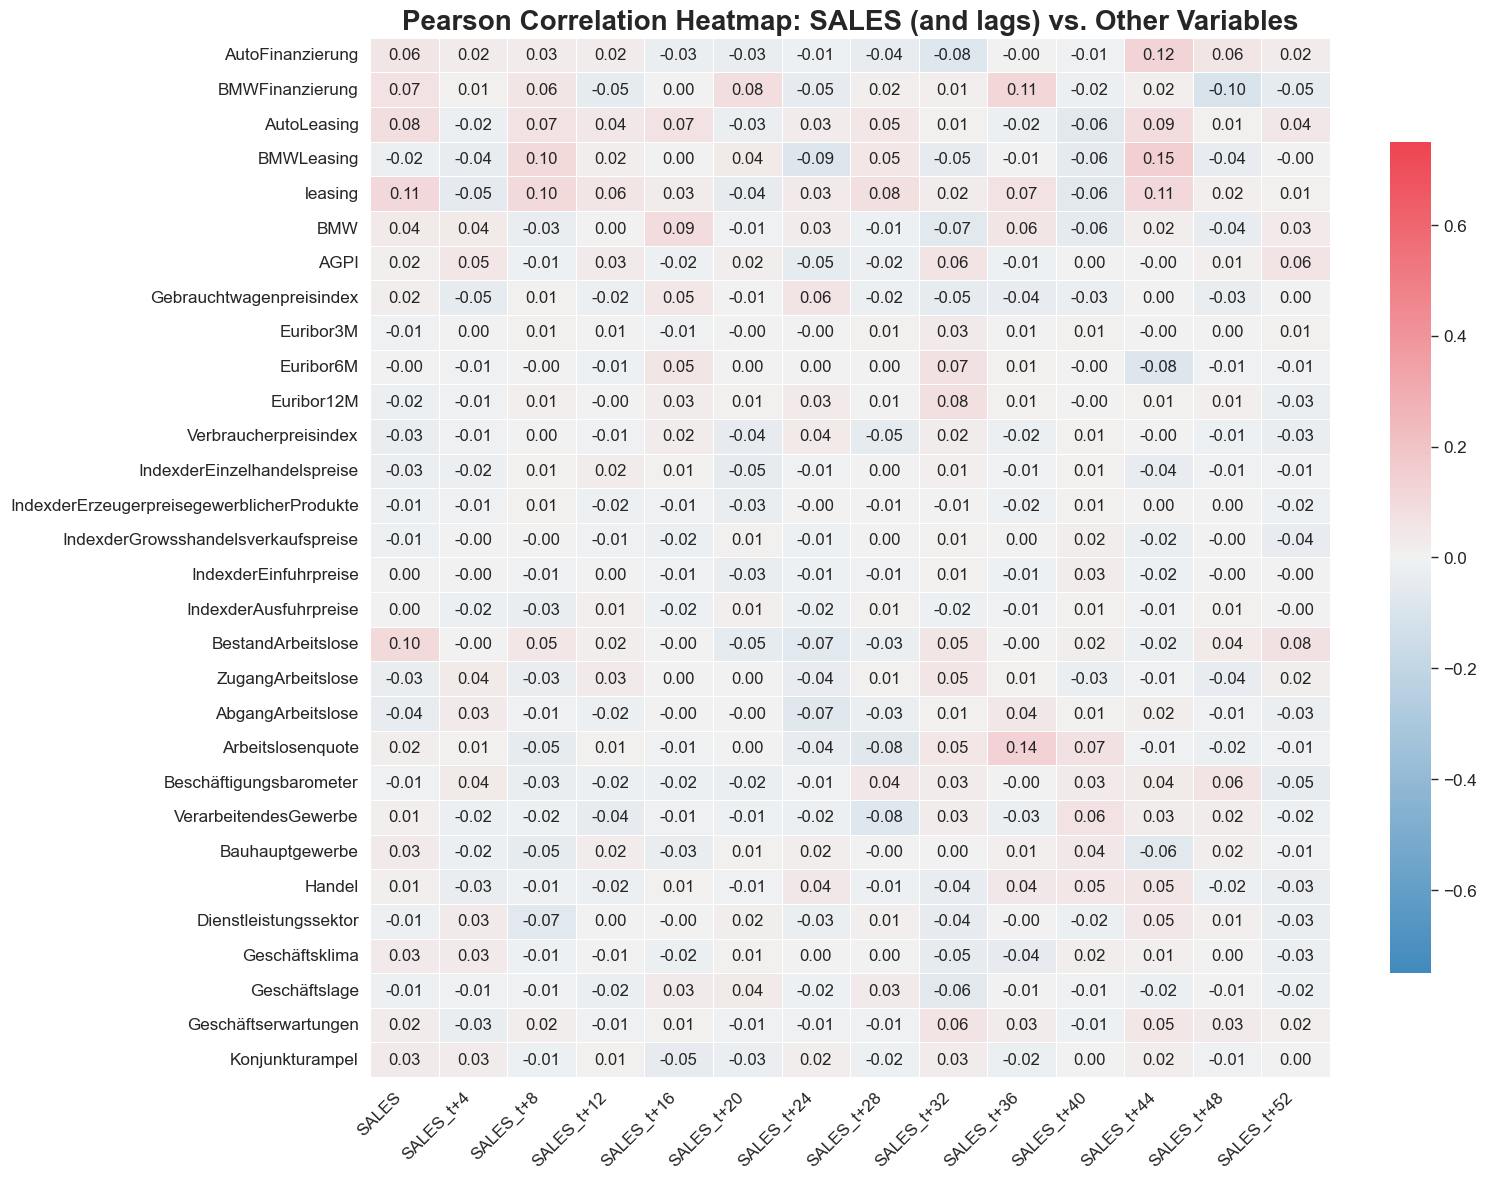

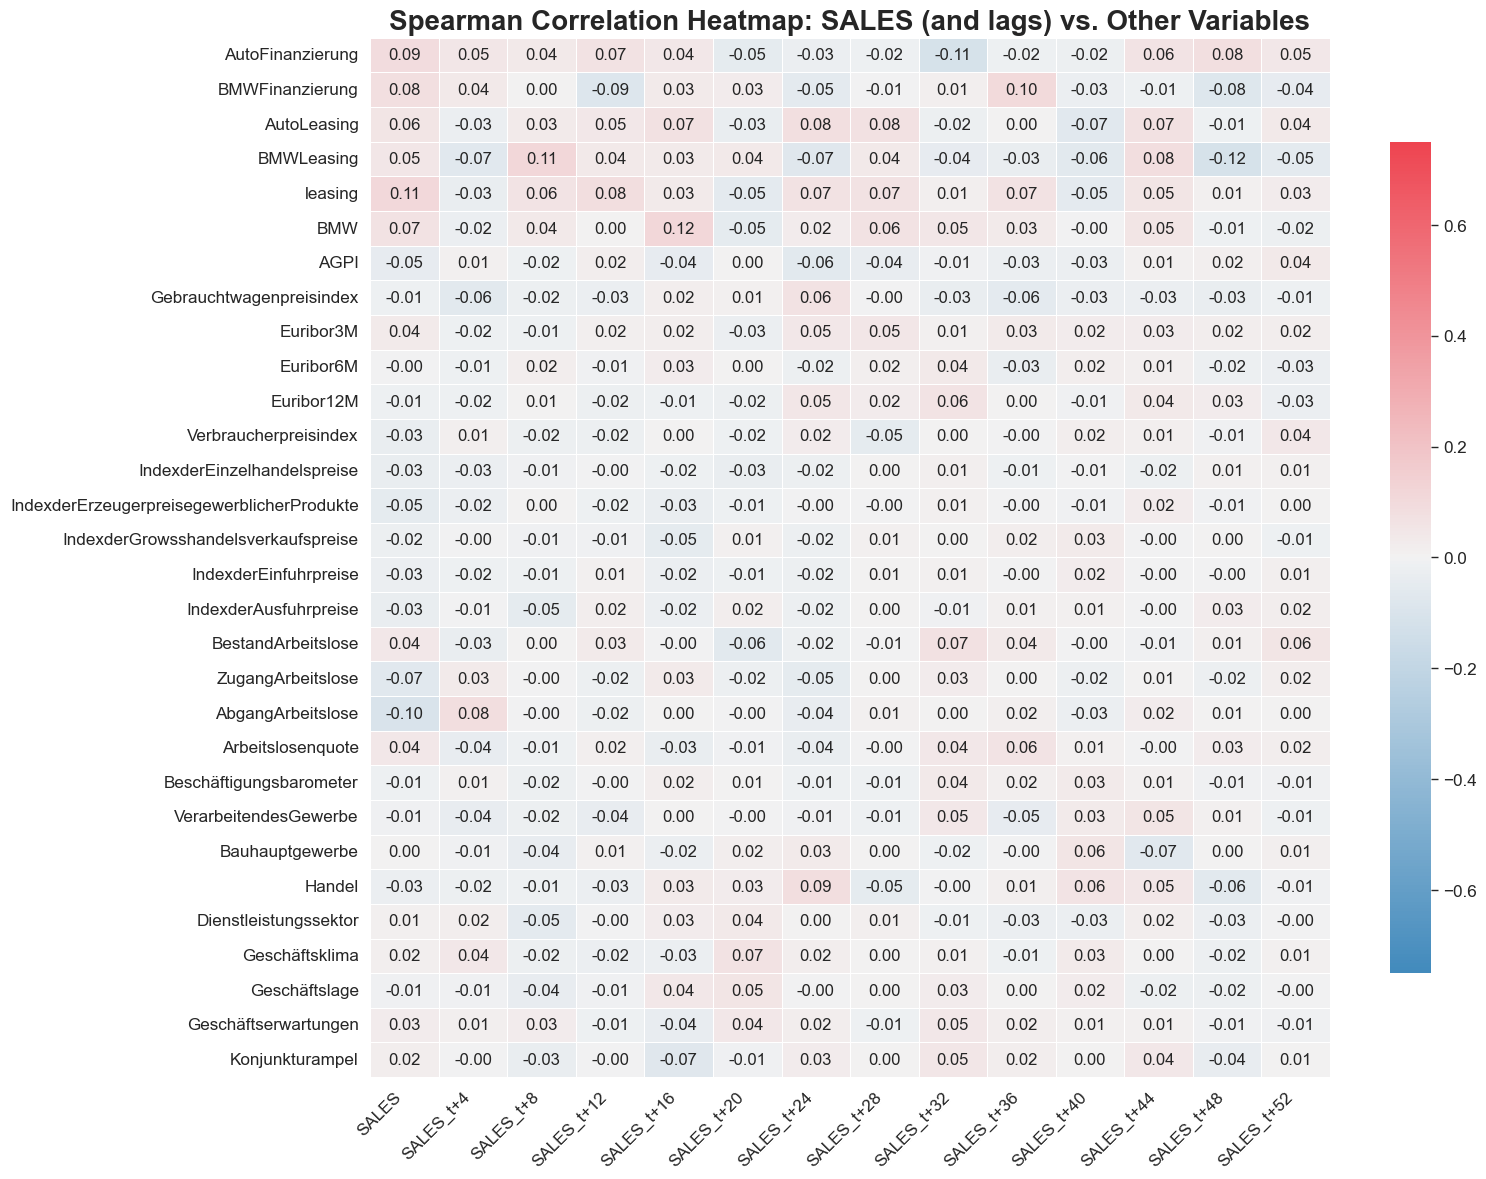

In [79]:
target_cols = ["SALES"] + [f"SALES_t+{i}" for i in range(4, 53, 4)]
other_cols = [col for col in df_fe.columns if col not in target_cols + ["DATE"]]

correlation_methods = ["pearson", "spearman"]
for method in correlation_methods:
    correlation_matrix = df_fe[target_cols + other_cols].corr(method=method)
    correlation_subset = correlation_matrix.loc[other_cols, target_cols]

    sns.set_style("whitegrid")
    sns.set_context("paper", font_scale=1.4)
    custom_palette = sns.diverging_palette(
        240, 10, s=80, l=55, n=256, center="light", as_cmap=True
    )

    plt.figure(figsize=(16, 12))
    sns.heatmap(
        correlation_subset,
        annot=True,
        cmap=custom_palette,
        fmt=".2f",
        vmin=-0.75,
        vmax=0.75,
        center=0,
        annot_kws={"size": 12},
        linewidths=0.5,
        cbar_kws={"shrink": 0.8},
    )

    plt.title(
        f"{method.capitalize()} Correlation Heatmap: SALES (and lags) vs. Other Variables",
        fontsize=20,
        fontweight="bold",
    )

    plt.xticks(rotation=45, ha="right")
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()


In [80]:
# Check Cointegration
from statsmodels.tsa.stattools import coint
from statsmodels.tsa.vector_ar.vecm import coint_johansen


def test_cointegration_pairwise(data, target_col="SALES", significance_level=0.05):
    """
    Test pairwise cointegration between target variable and all other variables
    using Engle-Granger two-step method
    """
    results = {}

    for col in data.columns:
        if col != target_col and col != "DATE":
            # Remove NaN values for the pair
            pair_data = data[[target_col, col]].dropna()

            if len(pair_data) > 10:  # Need sufficient data points
                try:
                    # Perform cointegration test
                    score, p_value, critical_values = coint(
                        pair_data[target_col], pair_data[col]
                    )

                    # Determine if cointegrated at given significance level
                    is_cointegrated = p_value < significance_level

                    results[col] = {
                        "cointegration_statistic": score,
                        "p_value": p_value,
                        "critical_values": {
                            "1%": critical_values[0],
                            "5%": critical_values[1],
                            "10%": critical_values[2],
                        },
                        "is_cointegrated_5%": is_cointegrated,
                        "sample_size": len(pair_data),
                    }
                except Exception as e:
                    results[col] = {"error": str(e)}

    return results


def test_johansen_cointegration(data, variables, det_order=0, k_ar_diff=1):
    """
    Test for multivariate cointegration using Johansen test
    """
    # Select variables and remove NaN
    test_data = data[variables].dropna()

    if len(test_data) < 20:
        return {"error": "Insufficient data for Johansen test"}

    try:
        # Perform Johansen cointegration test
        result = coint_johansen(test_data, det_order=det_order, k_ar_diff=k_ar_diff)

        return {
            "trace_stat": result.lr1,
            "max_eigenvalue_stat": result.lr2,
            "critical_values_trace": result.cvt,
            "critical_values_max_eigen": result.cvm,
            "eigenvalues": result.eig,
            "sample_size": len(test_data),
            "variables": variables,
        }
    except Exception as e:
        return {"error": str(e)}


# Test pairwise cointegration with original (non-differenced) data
# Use interpolated data before differencing for cointegration tests
cointegration_data = df_sa.copy()

print("=== PAIRWISE COINTEGRATION TESTS (Engle-Granger) ===")
print("Testing cointegration between SALES and other variables")
print("-" * 60)

pairwise_results = test_cointegration_pairwise(cointegration_data, target_col="SALES")

# Display results
cointegrated_vars = []
for var, result in pairwise_results.items():
    if "error" not in result:
        status = "COINTEGRATED" if result["is_cointegrated_5%"] else "NOT COINTEGRATED"
        print(f"{var:30} | p-value: {result['p_value']:.4f} | {status}")
        if result["is_cointegrated_5%"]:
            cointegrated_vars.append(var)
    else:
        print(f"{var:30} | ERROR: {result['error']}")

print(
    f"\nVariables cointegrated with SALES (5% significance): {len(cointegrated_vars)}"
)
for var in cointegrated_vars:
    print(f"  - {var}")

=== PAIRWISE COINTEGRATION TESTS (Engle-Granger) ===
Testing cointegration between SALES and other variables
------------------------------------------------------------
AutoFinanzierung               | p-value: 0.0000 | COINTEGRATED
BMWFinanzierung                | p-value: 0.0000 | COINTEGRATED
AutoLeasing                    | p-value: 0.0000 | COINTEGRATED
BMWLeasing                     | p-value: 0.0000 | COINTEGRATED
leasing                        | p-value: 0.0000 | COINTEGRATED
BMW                            | p-value: 0.0000 | COINTEGRATED
AGPI                           | p-value: 0.0000 | COINTEGRATED
Gebrauchtwagenpreisindex       | p-value: 0.0000 | COINTEGRATED
Euribor3M                      | p-value: 0.0000 | COINTEGRATED
Euribor6M                      | p-value: 0.0000 | COINTEGRATED
Euribor12M                     | p-value: 0.0000 | COINTEGRATED
Verbraucherpreisindex          | p-value: 0.0000 | COINTEGRATED
IndexderEinzelhandelspreise    | p-value: 0.0000 | COINTEGRATE

In [81]:
# Johansen multivariate cointegration test
print("\n=== JOHANSEN MULTIVARIATE COINTEGRATION TEST ===")

# Test with a subset of key variables (too many variables can cause issues)
key_variables = [
    "AGPI",
    "Euribor12M",
    "Verbraucherpreisindex",
    "BMW"
]

# Filter to only include variables that exist in the data
available_vars = [var for var in key_variables if var in cointegration_data.columns]

if len(available_vars) >= 2:
    print(f"Testing variables: {available_vars}")
    
    johansen_result = test_johansen_cointegration(cointegration_data, available_vars)
    
    if 'error' not in johansen_result:
        print(f"Sample size: {johansen_result['sample_size']}")
        print("\nTrace Statistics:")
        trace_stats = johansen_result['trace_stat']
        trace_critical = johansen_result['critical_values_trace']
        
        for i in range(len(trace_stats)):
            print(f"r <= {i}: Trace stat = {trace_stats[i]:.4f}, Critical values = {trace_critical[i]}")
            
        print("\nMax Eigenvalue Statistics:")
        max_eigen_stats = johansen_result['max_eigenvalue_stat']
        max_eigen_critical = johansen_result['critical_values_max_eigen']
        
        for i in range(len(max_eigen_stats)):
            print(f"r = {i}: Max eigen stat = {max_eigen_stats[i]:.4f}, Critical values = {max_eigen_critical[i]}")
            
        print(f"\nEigenvalues: {johansen_result['eigenvalues']}")
    else:
        print(f"Error in Johansen test: {johansen_result['error']}")
else:
    print("Insufficient variables available for Johansen test")


=== JOHANSEN MULTIVARIATE COINTEGRATION TEST ===
Testing variables: ['AGPI', 'Euribor12M', 'Verbraucherpreisindex', 'BMW']
Sample size: 541

Trace Statistics:
r <= 0: Trace stat = 683.5005, Critical values = [44.4929 47.8545 54.6815]
r <= 1: Trace stat = 464.1174, Critical values = [27.0669 29.7961 35.4628]
r <= 2: Trace stat = 250.1404, Critical values = [13.4294 15.4943 19.9349]
r <= 3: Trace stat = 73.0305, Critical values = [2.7055 3.8415 6.6349]

Max Eigenvalue Statistics:
r = 0: Max eigen stat = 219.3831, Critical values = [25.1236 27.5858 32.7172]
r = 1: Max eigen stat = 213.9770, Critical values = [18.8928 21.1314 25.865 ]
r = 2: Max eigen stat = 177.1100, Critical values = [12.2971 14.2639 18.52  ]
r = 3: Max eigen stat = 73.0305, Critical values = [2.7055 3.8415 6.6349]

Eigenvalues: [0.33436827 0.32765851 0.28006182 0.1267143 ]


In [82]:
# Create a summary table of cointegration results
print("\n=== COINTEGRATION SUMMARY ===")

if len(pairwise_results) > 0:
    # Create DataFrame for better visualization
    summary_data = []
    for var, result in pairwise_results.items():
        if 'error' not in result:
            summary_data.append({
                'Variable': var,
                'Cointegration_Stat': result['cointegration_statistic'],
                'P_Value': result['p_value'],
                'Cointegrated_5%': result['is_cointegrated_5%'],
                'Critical_1%': result['critical_values']['1%'],
                'Critical_5%': result['critical_values']['5%'],
                'Critical_10%': result['critical_values']['10%'],
                'Sample_Size': result['sample_size']
            })
    
    if summary_data:
        summary_df = pd.DataFrame(summary_data)
        summary_df = summary_df.sort_values('P_Value')
        
        print("\nTop 10 variables by cointegration strength (lowest p-values):")
        print(summary_df.head(10)[['Variable', 'P_Value', 'Cointegrated_5%', 'Sample_Size']].to_string(index=False))
        
        # Count cointegrated relationships
        cointegrated_count = summary_df['Cointegrated_5%'].sum()
        total_count = len(summary_df)
        
        print(f"\nSummary:")
        print(f"Total variables tested: {total_count}")
        print(f"Cointegrated relationships (5% level): {cointegrated_count}")
        print(f"Percentage cointegrated: {(cointegrated_count/total_count)*100:.1f}%")
        
        # Show interpretation
        print(f"\nInterpretation:")
        print(f"- Cointegration indicates long-term equilibrium relationships")
        print(f"- Variables with p-value < 0.05 are cointegrated with BMW SALES")
        print(f"- These relationships suggest predictive power for long-term forecasting")
    else:
        print("No valid cointegration results to display")
else:
    print("No cointegration tests were performed")


=== COINTEGRATION SUMMARY ===

Top 10 variables by cointegration strength (lowest p-values):
             Variable      P_Value  Cointegrated_5%  Sample_Size
        Geschäftslage 1.924456e-27             True          541
Dienstleistungssektor 2.291401e-27             True          541
    AbgangArbeitslose 2.914247e-27             True          541
   BestandArbeitslose 4.663673e-27             True          541
 Geschäftserwartungen 1.422916e-14             True          541
      Konjunkturampel 1.473064e-14             True          541
      Bauhauptgewerbe 1.623762e-14             True          541
              leasing 2.848930e-14             True          541
Verbraucherpreisindex 3.021560e-14             True          541
           Euribor12M 3.100738e-14             True          541

Summary:
Total variables tested: 30
Cointegrated relationships (5% level): 30
Percentage cointegrated: 100.0%

Interpretation:
- Cointegration indicates long-term equilibrium relationships
-

## Choice of Variables
- AGPI
- Euribor12M
- Verbraucherpreisindex
- BMW


In [83]:
# VECM
from statsmodels.tsa.vector_ar.vecm import VECM


  